# FL Metrics Comparison

Compare MNIST global metrics across centralized, federation, and decentralized runs,
then compare communication costs and training time, and plot Adult global accuracy.

In [316]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [317]:
cwd = Path.cwd()
if (cwd / 'runs').exists():
    base = cwd / 'runs'
elif cwd.name == 'runs':
    base = cwd
else:
    base = cwd / 'runs'
paths = {
    'centralized': base / 'fluke_mnist_noniid_traces_centralized',
    'federation': base / 'fluke_mnist_noniid_traces',
    'decentralized': base / 'fluke_mnist_noniid_traces_FL_dec',
}
adult_paths = {
    'centralized': (base / 'adult_centralized').resolve(),
    'federation': (base / 'adult_fedavg').resolve(),
    'decentralized': (base / 'adult_decentralized').resolve(),
}

def load_global_metrics(run_path: Path) -> pd.DataFrame:
    global_csv = run_path / 'global_metrics.csv'
    metrics_csv = run_path / 'metrics.csv'
    if global_csv.exists():
        return pd.read_csv(global_csv)
    if metrics_csv.exists():
        return pd.read_csv(metrics_csv)
    raise FileNotFoundError(f'No global metrics CSV in {run_path}')

def load_comm_costs(run_path: Path):
    path = run_path / 'comm_costs.csv'
    return pd.read_csv(path) if path.exists() else None

def load_run_time(run_path: Path):
    path = run_path / 'run_metrics.csv'
    if not path.exists():
        return None
    df = pd.read_csv(path)
    row = df[df['metric'] == 'run_time_seconds']
    if row.empty:
        return None
    return float(row['value'].iloc[0])

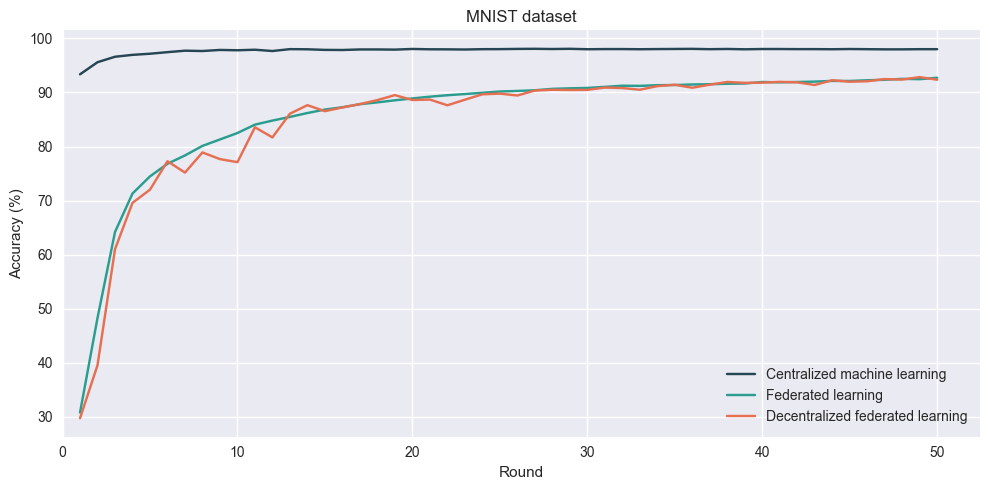

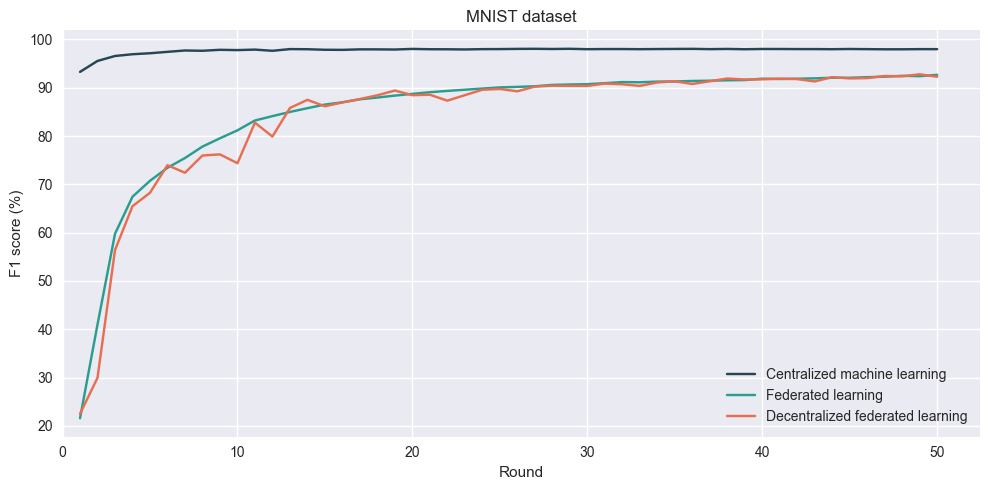

In [318]:
metrics = {name: load_global_metrics(path) for name, path in paths.items()}
legend_map = {
    'centralized': 'Centralized machine learning',
    'federation': 'Federated learning',
    'decentralized': 'Decentralized federated learning',
}
color_map = {
    'centralized': '#264653',
    'federation': '#2A9D8F',
    'decentralized': '#E76F51',
}

plt.figure(figsize=(10, 5))
for name, df in metrics.items():
    plt.plot(
        df['round'],
        df['accuracy'] * 100,
        label=legend_map.get(name, name),
        color=color_map.get(name),
    )
plt.title('MNIST dataset')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for name, df in metrics.items():
    if 'macro_f1' in df.columns:
        plt.plot(
            df['round'],
            df['macro_f1'] * 100,
            label=legend_map.get(name, name),
            color=color_map.get(name),
        )
plt.title('MNIST dataset')
plt.xlabel('Round')
plt.ylabel('F1 score (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

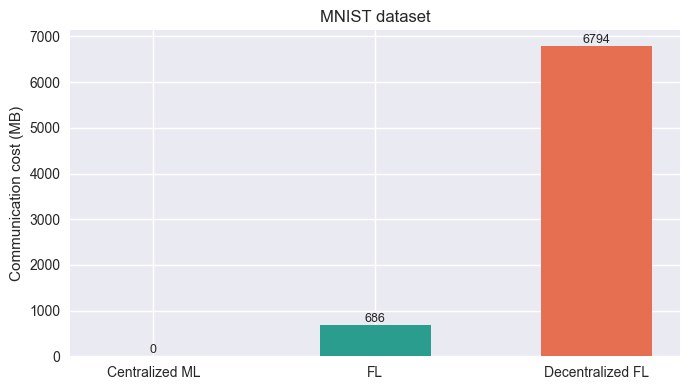

In [319]:
comm_totals = {}
for name, path in paths.items():
    df = load_comm_costs(path)
    comm_totals[name] = df['comm_costs'].sum() if df is not None else 0

bytes_per_param = 4
comm_totals_mb = {k: (v * bytes_per_param) / (1024**2) for k, v in comm_totals.items()}

order = ['centralized', 'federation', 'decentralized']
labels = ['Centralized ML', 'FL', 'Decentralized FL']
colors = ['#264653', '#2A9D8F', '#E76F51']
values = [comm_totals_mb.get(k, 0) for k in order]

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, values, color=colors, width=0.5)
plt.title('MNIST dataset')
plt.ylabel('Communication cost (MB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

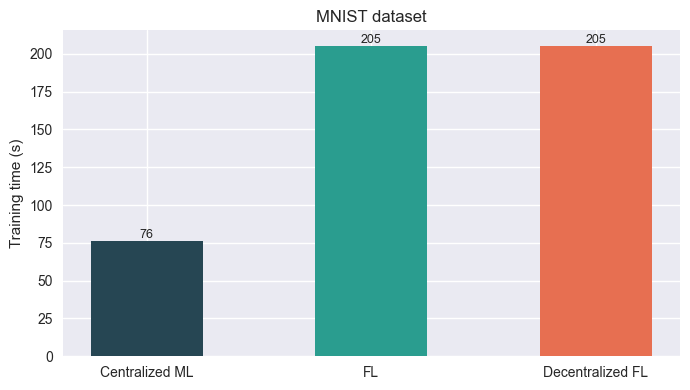

In [320]:
run_times = {name: load_run_time(path) for name, path in paths.items()}

order = ['centralized', 'federation', 'decentralized']
labels = ['Centralized ML', 'FL', 'Decentralized FL']
colors = ['#264653', '#2A9D8F', '#E76F51']
values = [run_times.get(k, 0) if run_times.get(k) is not None else 0 for k in order]

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, values, color=colors, width=0.5)
plt.title('MNIST dataset')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

Adult metrics loaded: ['centralized', 'federation', 'decentralized']


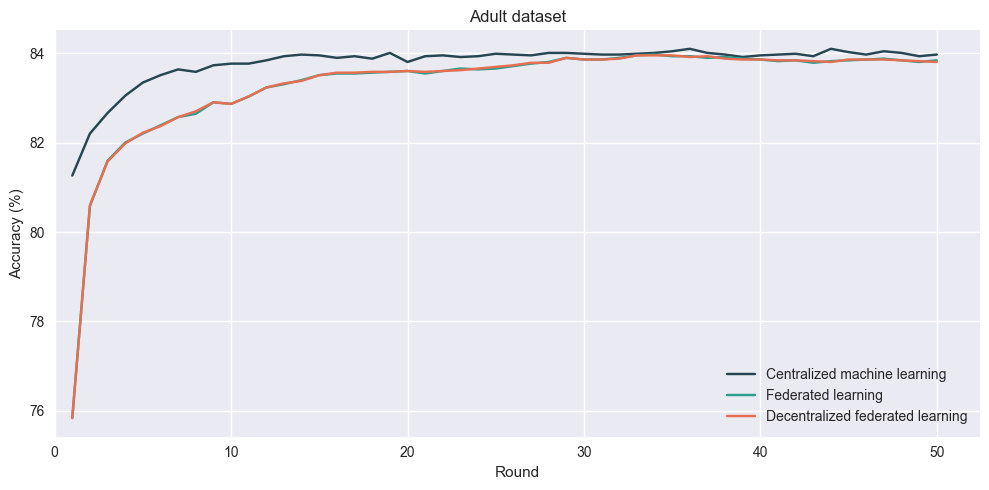

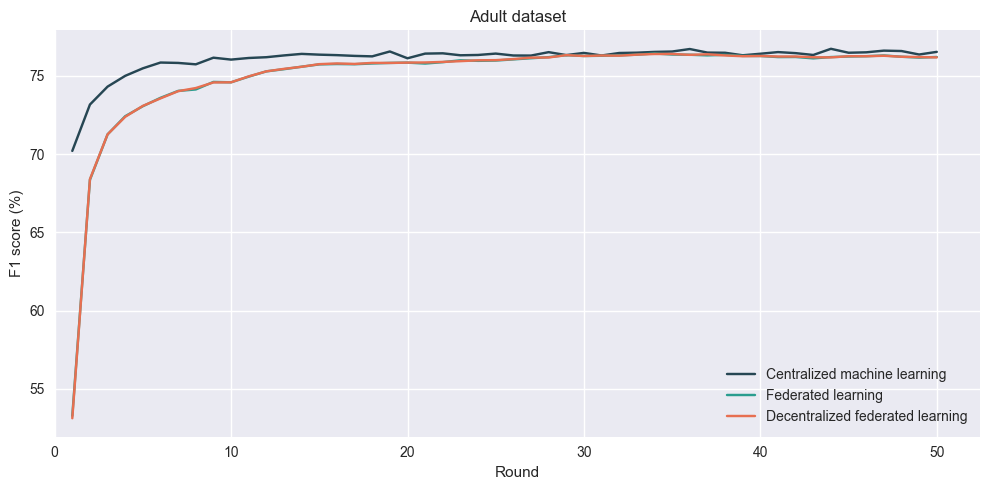

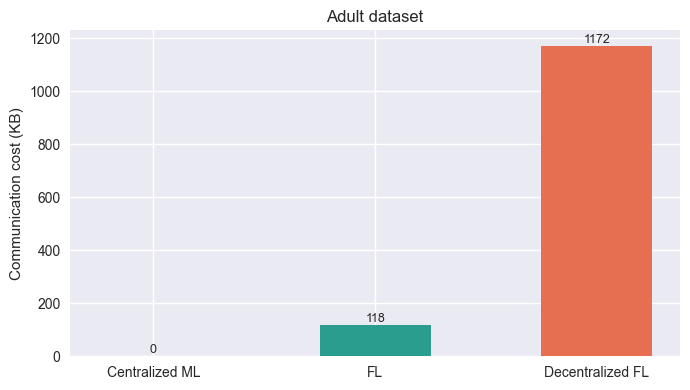

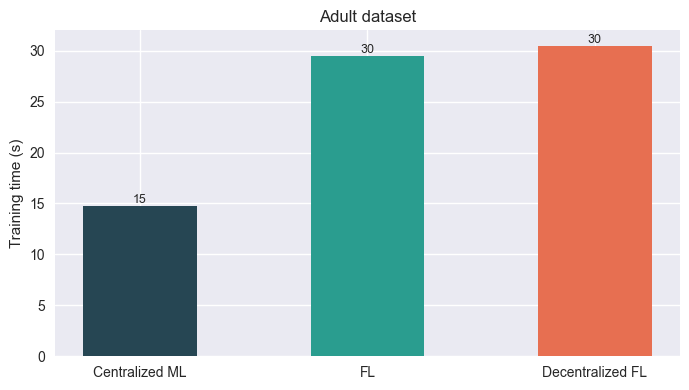

In [321]:
adult_metrics = {
    name: load_global_metrics(adult_paths[name])
    for name in ['centralized', 'federation', 'decentralized']
}
print('Adult metrics loaded:', list(adult_metrics.keys()))

plt.figure(figsize=(10, 5))
for name in ['centralized', 'federation', 'decentralized']:
    if name not in adult_metrics:
        continue
    df = adult_metrics[name]
    plt.plot(
        df['round'],
        df['accuracy'] * 100,
        label=legend_map.get(name, name),
        color=color_map.get(name),
    )
plt.title('Adult dataset')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for name in ['centralized', 'federation', 'decentralized']:
    if name not in adult_metrics:
        continue
    df = adult_metrics[name]
    if 'macro_f1' in df.columns:
        plt.plot(
            df['round'],
            df['macro_f1'] * 100,
            label=legend_map.get(name, name),
            color=color_map.get(name),
        )
plt.title('Adult dataset')
plt.xlabel('Round')
plt.ylabel('F1 score (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

adult_comm_totals = {}
for name, path in adult_paths.items():
    df = load_comm_costs(path)
    adult_comm_totals[name] = df['comm_costs'].sum() if df is not None else 0

bytes_per_param = 4
adult_comm_totals_kb = {
    k: (v * bytes_per_param) / 1024 for k, v in adult_comm_totals.items()
}

order = ['centralized', 'federation', 'decentralized']
labels = ['Centralized ML', 'FL', 'Decentralized FL']
colors = ['#264653', '#2A9D8F', '#E76F51']
values = [adult_comm_totals_kb.get(k, 0) for k in order]

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, values, color=colors, width=0.5)
plt.title('Adult dataset')
plt.ylabel('Communication cost (KB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

adult_run_times = {name: load_run_time(path) for name, path in adult_paths.items()}
values = [adult_run_times.get(k, 0) if adult_run_times.get(k) is not None else 0 for k in order]

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, values, color=colors, width=0.5)
plt.title('Adult dataset')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

Adult MLP metrics loaded: ['centralized', 'federation', 'decentralized']


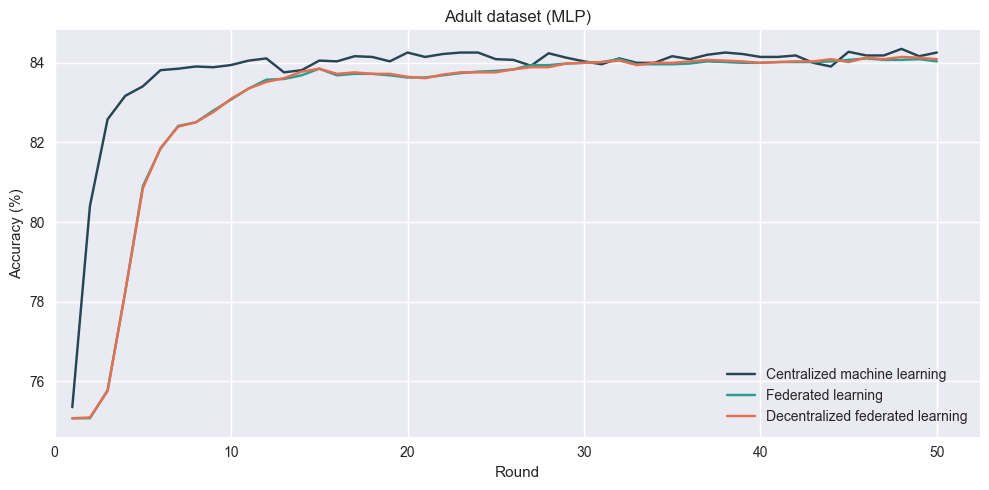

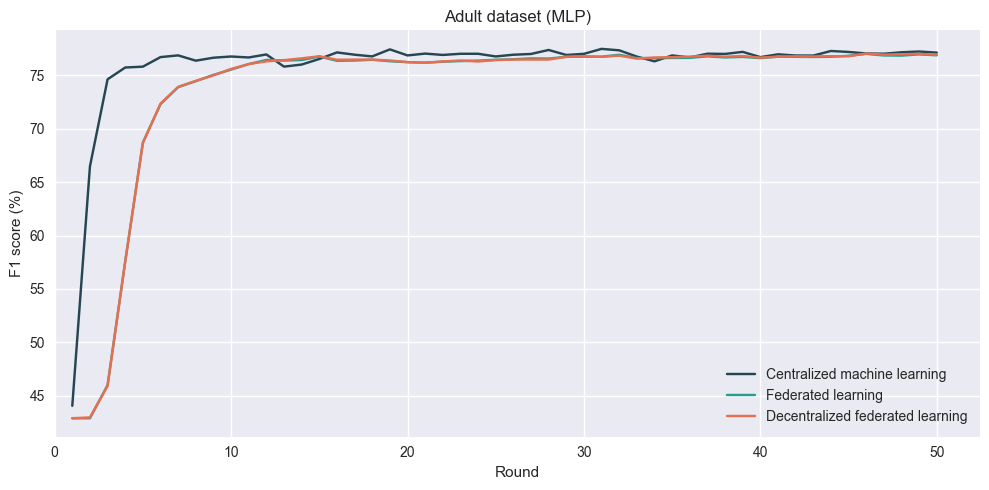

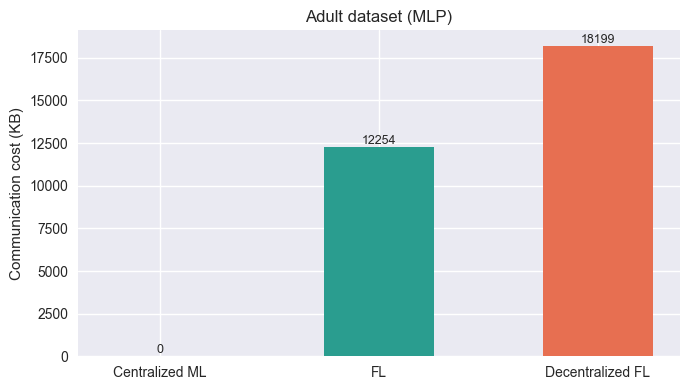

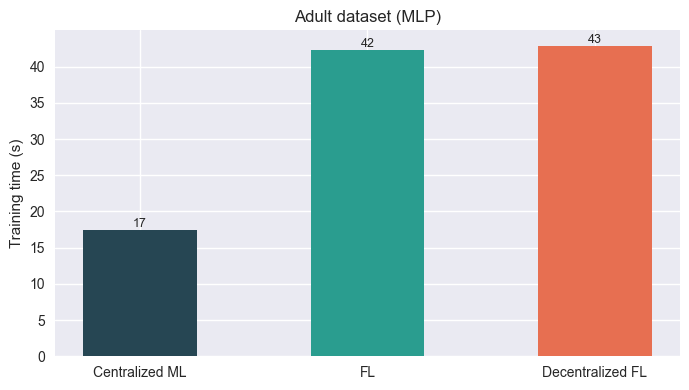

In [322]:
adult_mlp_paths = {
    'centralized': (base / 'adult_MLP_centralized').resolve(),
    'federation': (base / 'adult_MLP').resolve(),
    'decentralized': (base / 'adult_MLP_decentralized').resolve(),
}

adult_mlp_metrics = {
    name: load_global_metrics(adult_mlp_paths[name])
    for name in ['centralized', 'federation', 'decentralized']
}
print('Adult MLP metrics loaded:', list(adult_mlp_metrics.keys()))

plt.figure(figsize=(10, 5))
for name in ['centralized', 'federation', 'decentralized']:
    df = adult_mlp_metrics[name]
    plt.plot(
        df['round'],
        df['accuracy'] * 100,
        label=legend_map.get(name, name),
        color=color_map.get(name),
    )
plt.title('Adult dataset (MLP)')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for name in ['centralized', 'federation', 'decentralized']:
    df = adult_mlp_metrics[name]
    if 'macro_f1' in df.columns:
        plt.plot(
            df['round'],
            df['macro_f1'] * 100,
            label=legend_map.get(name, name),
            color=color_map.get(name),
        )
plt.title('Adult dataset (MLP)')
plt.xlabel('Round')
plt.ylabel('F1 score (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

adult_mlp_comm = {}
for name, path in adult_mlp_paths.items():
    df = load_comm_costs(path)
    adult_mlp_comm[name] = df['comm_costs'].sum() if df is not None else 0

bytes_per_param = 4
adult_mlp_comm_kb = {k: (v * bytes_per_param) / 1024 for k, v in adult_mlp_comm.items()}
order = ['centralized', 'federation', 'decentralized']
labels = ['Centralized ML', 'FL', 'Decentralized FL']
colors = ['#264653', '#2A9D8F', '#E76F51']
values = [adult_mlp_comm_kb.get(k, 0) for k in order]

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, values, color=colors, width=0.5)
plt.title('Adult dataset (MLP)')
plt.ylabel('Communication cost (KB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

adult_mlp_run_times = {name: load_run_time(path) for name, path in adult_mlp_paths.items()}
values = [adult_mlp_run_times.get(k, 0) if adult_mlp_run_times.get(k) is not None else 0 for k in order]

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, values, color=colors, width=0.5)
plt.title('Adult dataset (MLP)')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


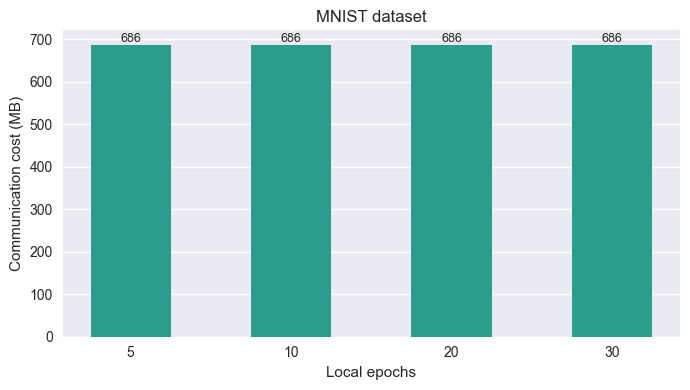

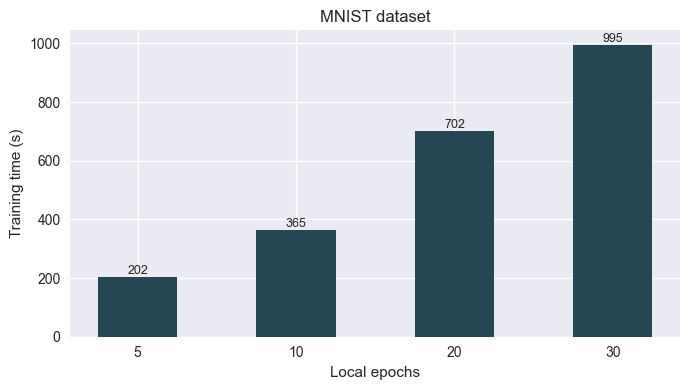

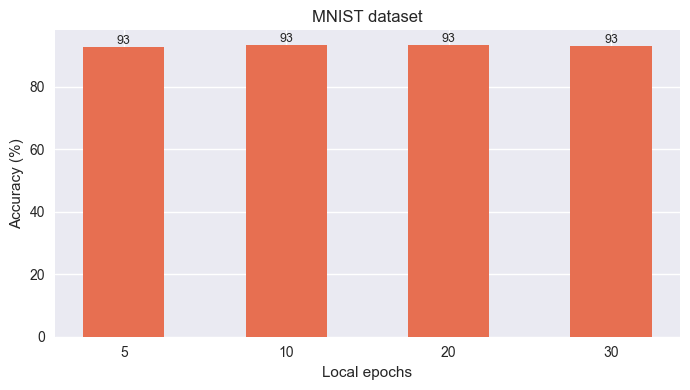

In [323]:
lep_paths = {
    5: base / 'fluke_mnist_noniid_traces-lep-5',
    10: base / 'fluke_mnist_noniid_traces-lep-10',
    20: base / 'fluke_mnist_noniid_traces-lep-20',
    30: base / 'fluke_mnist_noniid_traces-lep-30',
}

lep_comm_mb = {}
lep_time = {}
lep_acc = {}
for k, path in lep_paths.items():
    comm_df = load_comm_costs(path)
    lep_comm_mb[k] = (comm_df['comm_costs'].sum() * 4) / (1024**2) if comm_df is not None else 0
    lep_time[k] = load_run_time(path) or 0
    metrics_df = load_global_metrics(path)
    lep_acc[k] = float(metrics_df['accuracy'].iloc[-1]) * 100

x = sorted(lep_paths.keys())

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [lep_comm_mb[v] for v in x], color='#2A9D8F', width=0.5)
plt.title('MNIST dataset')
plt.xlabel('Local epochs')
plt.ylabel('Communication cost (MB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [lep_time[v] for v in x], color='#264653', width=0.5)
plt.title('MNIST dataset')
plt.xlabel('Local epochs')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [lep_acc[v] for v in x], color='#E76F51', width=0.5)
plt.title('MNIST dataset')
plt.xlabel('Local epochs')
plt.ylabel('Accuracy (%)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


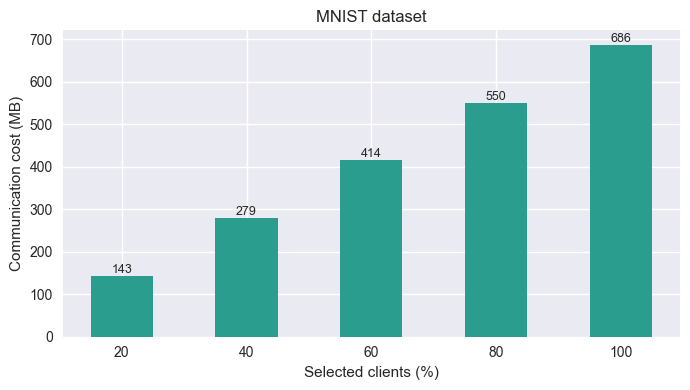

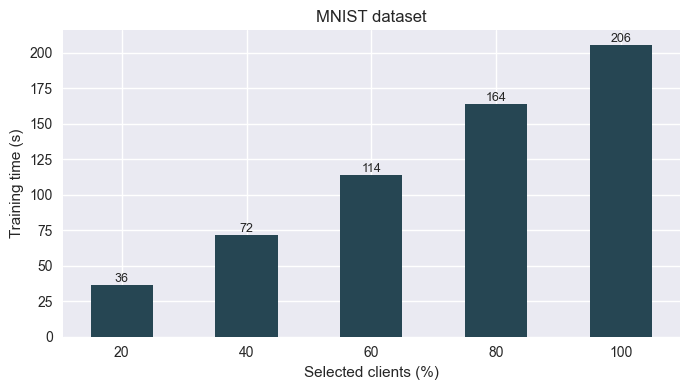

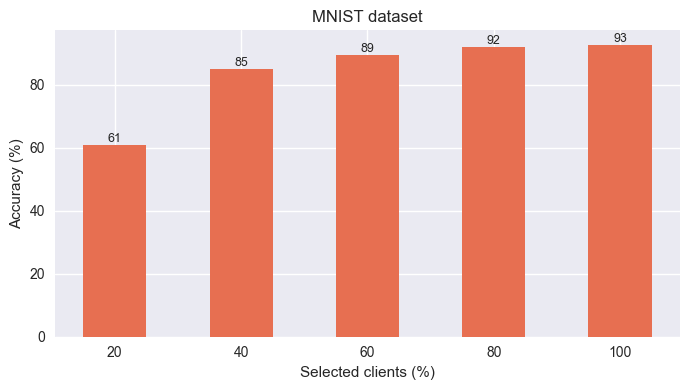

In [324]:
client_paths = {
    20: base / 'fluke_mnist_noniid_traces-cl-20',
    40: base / 'fluke_mnist_noniid_traces-cl-40',
    60: base / 'fluke_mnist_noniid_traces-cl-60',
    80: base / 'fluke_mnist_noniid_traces-cl-80',
    100: base / 'fluke_mnist_noniid_traces-cl-100',
}

cl_comm_mb = {}
cl_time = {}
cl_acc = {}
for k, path in client_paths.items():
    comm_df = load_comm_costs(path)
    cl_comm_mb[k] = (comm_df['comm_costs'].sum() * 4) / (1024**2) if comm_df is not None else 0
    cl_time[k] = load_run_time(path) or 0
    metrics_df = load_global_metrics(path)
    cl_acc[k] = float(metrics_df['accuracy'].iloc[-1]) * 100

x = sorted(client_paths.keys())

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [cl_comm_mb[v] for v in x], color='#2A9D8F', width=0.5)
plt.title('MNIST dataset')
plt.xlabel('Selected clients (%)')
plt.ylabel('Communication cost (MB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [cl_time[v] for v in x], color='#264653', width=0.5)
plt.title('MNIST dataset')
plt.xlabel('Selected clients (%)')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [cl_acc[v] for v in x], color='#E76F51', width=0.5)
plt.title('MNIST dataset')
plt.xlabel('Selected clients (%)')
plt.ylabel('Accuracy (%)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


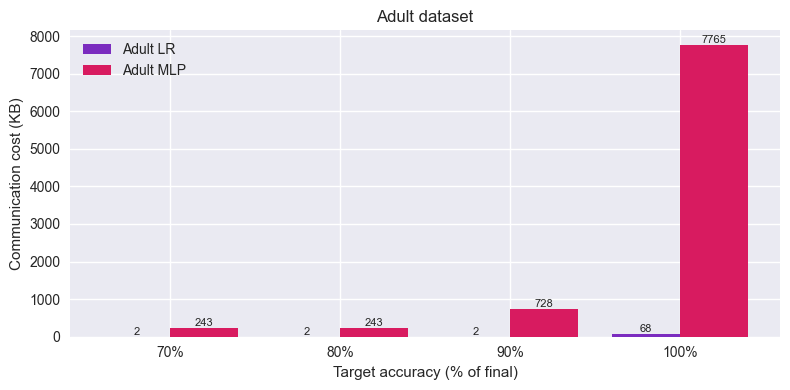

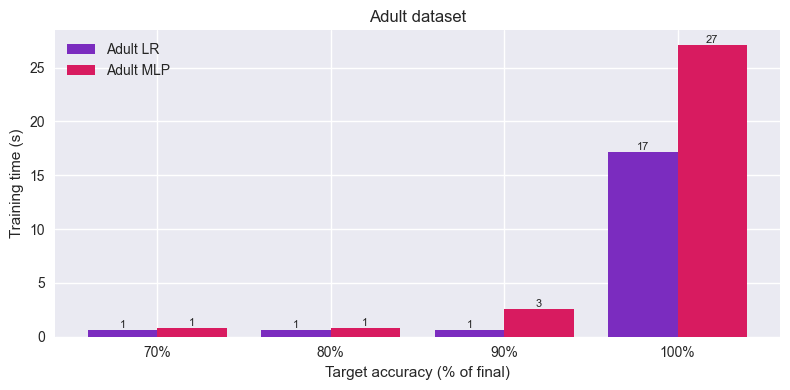

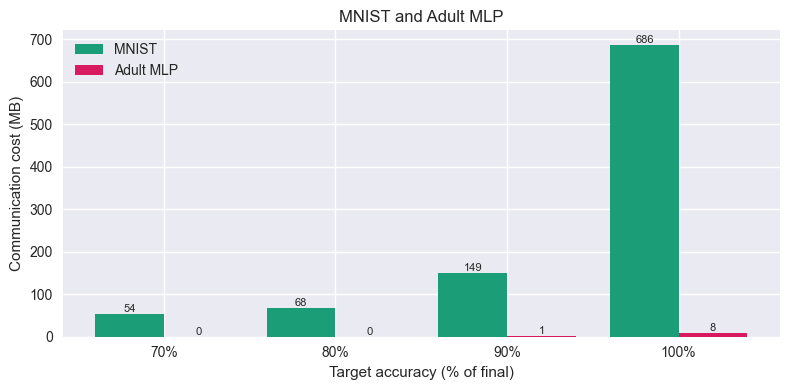

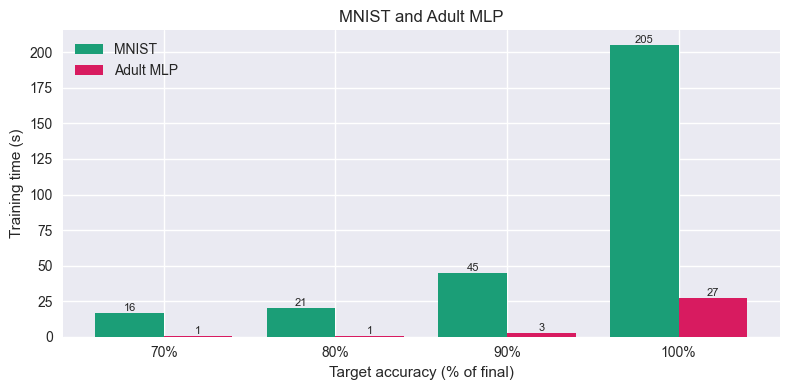

In [325]:
thresholds = [0.7, 0.8, 0.9, 1.0]
threshold_labels = ['70%', '80%', '90%', '100%']

def _comm_until(comm_df, target_round, unit='MB'):
    if comm_df is None or comm_df.empty:
        return 0
    total = comm_df[comm_df['round'] <= target_round]['comm_costs'].sum()
    bytes_per_param = 4
    if unit == 'KB':
        return (total * bytes_per_param) / 1024
    return (total * bytes_per_param) / (1024**2)

def compute_cost_to_accuracy(run_path, comm_unit='MB'):
    metrics_df = load_global_metrics(run_path)
    acc = metrics_df['accuracy'] * 100
    final_acc = float(acc.iloc[-1])
    round_vals = metrics_df['round'].astype(int)

    comm_df = load_comm_costs(run_path)
    run_time = load_run_time(run_path) or 0
    max_round = int(round_vals.max()) if len(round_vals) else 0
    time_per_round = (run_time / max_round) if max_round > 0 else 0

    comm_to_acc = []
    time_to_acc = []
    for t in thresholds:
        target = final_acc * t
        reached = round_vals[acc >= target]
        if reached.empty:
            comm_to_acc.append(float('nan'))
            time_to_acc.append(float('nan'))
            continue
        r = int(reached.iloc[0])
        comm_to_acc.append(_comm_until(comm_df, r, unit=comm_unit))
        time_to_acc.append(time_per_round * r)

    return comm_to_acc, time_to_acc

def plot_cost_to_accuracy(run_map, title, comm_unit='MB', colors=None):
    if colors is None:
        colors = ['#1B9E77', '#7B2CBF', '#D81B60', '#55A630', '#C77DFF']
    keys = list(run_map.keys())
    comm_data = []
    time_data = []
    for k in keys:
        comm_vals, time_vals = compute_cost_to_accuracy(run_map[k], comm_unit=comm_unit)
        comm_data.append(comm_vals)
        time_data.append(time_vals)

    x = range(len(thresholds))
    width = 0.8 / max(1, len(keys))

    plt.figure(figsize=(8, 4))
    for i, (k, vals) in enumerate(zip(keys, comm_data)):
        bars = plt.bar([xi + i * width for xi in x], vals, width=width, label=k, color=colors[i % len(colors)])
        for bar in bars:
            height = bar.get_height()
            if height == height:
                plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
                         ha='center', va='bottom', fontsize=8)
    plt.title(title)
    plt.xlabel('Target accuracy (% of final)')
    plt.ylabel(f'Communication cost ({comm_unit})')
    plt.xticks([xi + width * (len(keys) - 1) / 2 for xi in x], threshold_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    for i, (k, vals) in enumerate(zip(keys, time_data)):
        bars = plt.bar([xi + i * width for xi in x], vals, width=width, label=k, color=colors[i % len(colors)])
        for bar in bars:
            height = bar.get_height()
            if height == height:
                plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
                         ha='center', va='bottom', fontsize=8)
    plt.title(title)
    plt.xlabel('Target accuracy (% of final)')
    plt.ylabel('Training time (s)')
    plt.xticks([xi + width * (len(keys) - 1) / 2 for xi in x], threshold_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

adult_compare = {
    'Adult LR': adult_paths['federation'],
    'Adult MLP': adult_mlp_paths['federation'],
}
plot_cost_to_accuracy(adult_compare, 'Adult dataset', comm_unit='KB', colors=['#7B2CBF', '#D81B60'])

mnist_adult_mlp = {
    'MNIST': paths['federation'],
    'Adult MLP': adult_mlp_paths['federation'],
}
plot_cost_to_accuracy(mnist_adult_mlp, 'MNIST and Adult MLP', comm_unit='MB', colors=['#1B9E77', '#D81B60'])
